In [1]:
import copy
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
#from keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from IPython.display import Image

import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
W = 224 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 224 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'No_helipad': 0,
    'Helipad': 1
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

In [3]:
def get_images(dir_name='C:\\Users\\AatishNehe\\Downloads\\Helipad\\helipad 0 & helipad 1', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('\\'.join([dir_name, label_name])):
            img = load_img('\\'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [4]:
Images, Classes = get_images()

Images.shape, Classes.shape

((14324, 224, 224, 3), (14324,))

No_helipad 10000 0.6981290142418319


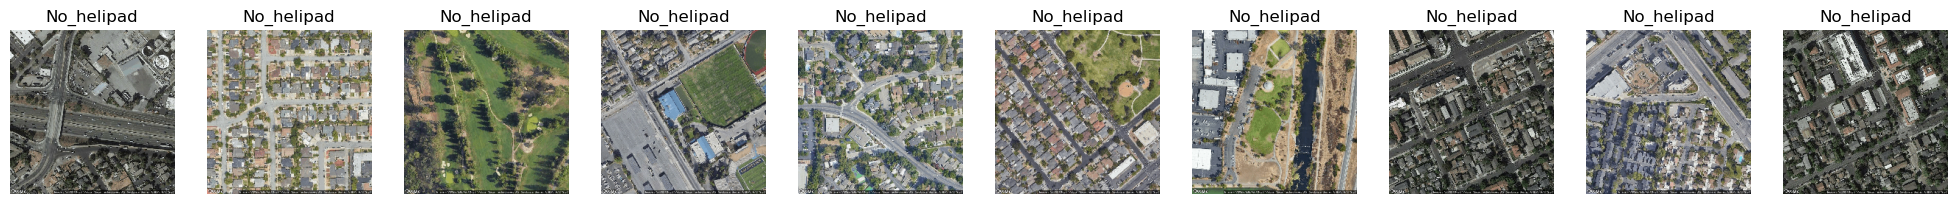

Helipad 4324 0.3018709857581681


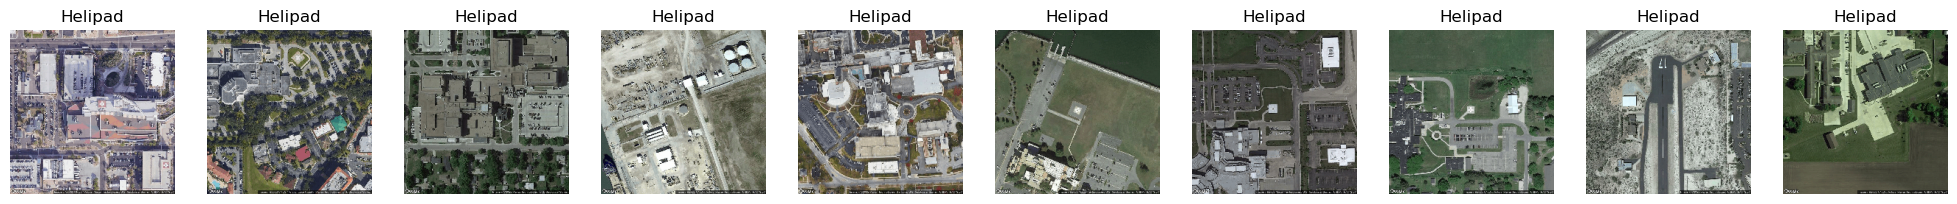

In [5]:
## visualize some images / labels
n_total_images = Images.shape[0]

for target_cls in [0, 1]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [6]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11459, 224, 224, 3), (11459,), (2865, 224, 224, 3), (2865,))

In [7]:
## to one-hot

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((11459, 2), (2865, 2))

In [8]:
## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [9]:
def build_model():
    """build model function"""
    
    # Resnet
    input_tensor = Input(shape=(W, H, 3)) # To change input shape
    #xception = Xception(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')# Shape of our images
    resnet = ResNet50(input_shape = (224, 224, 3), include_top = False, weights='imagenet')    
    
    # frozen weights
    for layer in resnet.layers[:]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
               
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation='softmax')) # Change output shape for this task
    
    # model
    model = Model(resnet.input, top_model(resnet.output))
    
    # compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
#checkpoint_filepath = '{epoch:02d}-{val_loss:.7f}.hdf5'
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [14]:
## finetuning

history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=32),
                              epochs=10,
                              validation_data=datagen_test.flow(x_test, y_test, batch_size=32),
                              steps_per_epoch = 100,
                              validation_steps=10,
                              shuffle = True,
                              callbacks=callbacks
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9100
Epoch 1: val_loss improved from inf to 0.24161, saving model to 01.h5
100/100 [==============================] - 360s 4s/step - loss: 0.2213 - accuracy: 0.9100 - val_loss: 0.2416 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9450
Epoch 2: val_loss improved from 0.24161 to 0.09039, saving model to 02.h5
100/100 [==============================] - 341s 3s/step - loss: 0.1424 - accuracy: 0.9450 - val_loss: 0.0904 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9525
Epoch 3: val_loss did not improve from 0.09039
100/100 [==============================] - 342s 3s/step - loss: 0.1225 - accuracy: 0.9525 - val_loss: 0.1049 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1032 - accurac

90/90 [==============================] - 126s 1s/step


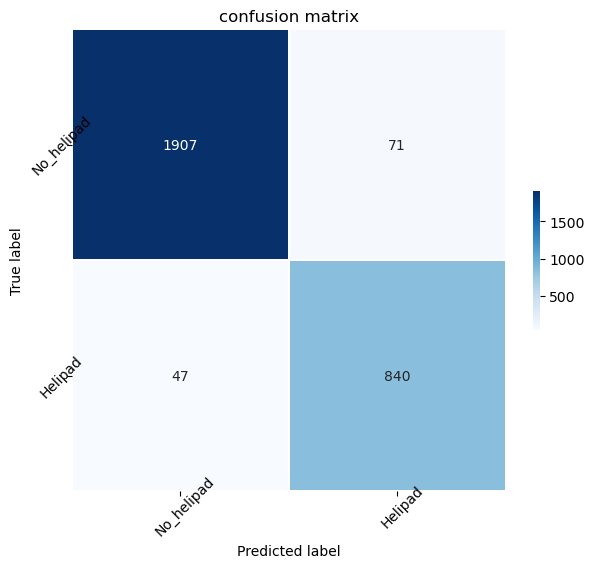

In [15]:
## plot confusion matrix

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [16]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [17]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(x, model=model, last_conv_layer_name = model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

In [18]:
def grad_cam(img_array, model, last_conv_layer_name, classifier_layer_names = ['sequential']):
    """Grad-CAM function"""
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    

    return top_pred_index, heatmap

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

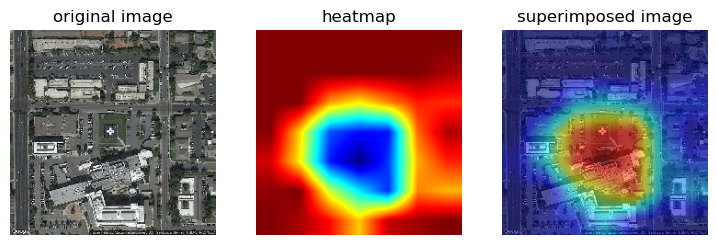

In [19]:
_plot(model=model, cam_func=grad_cam, img=Images[13000], cls_true=Classes[0])

In [20]:
!mkdir -p saved_model

In [20]:
model.save('saved_model_ResNet50/my_model1')

INFO:tensorflow:Assets written to: saved_model_ResNet50/my_model1\assets


INFO:tensorflow:Assets written to: saved_model_ResNet50/my_model1\assets


In [8]:
new_model = tf.keras.models.load_model('saved_model_ResNet50/my_model')

In [9]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [5]:
loss, acc = new_model.evaluate(preprocess_input(copy.deepcopy(x_test)), y_test, verbose=2)

NameError: name 'x_test' is not defined

In [27]:
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Restored model, accuracy: 97.70%


In [21]:
print(new_model.predict(preprocess_input(copy.deepcopy(x_test))))


90/90 [==============================] - 104s 1s/step
(2865, 2)


In [4]:
img = load_img('C:\\Users\\AatishNehe\\Downloads\\trial.jpg')
img = img.resize((224,224))

In [5]:
img = img_to_array(img)

In [12]:
print(new_model.predict(preprocess_input(img.reshape(1,224,224,3))))

1/1 [==============================] - 2s 2s/step
[[0.20766261 0.79233736]]
